<a href="https://colab.research.google.com/github/insyspo/issi2025_lattes/blob/main/ISSI_2025_authors_Lattes_OpenAlex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Research Entities Disambiguation Methodology Tested on Brazilian Researchers Database

Steps

- Lattes CV was scraped for all researchers with doctor degree active in the last 5 years. Researchers are uniquely indentified given the nature of the database.
- The publications are in table on BigQuery, as well as names.
- A portion of publications have DOIs.
- DOIs are used to collect author names on a public version of OpenAlex.
- All names for researchers and all distinct DOIs are collected and the method is then applied.
- The list of coauthors on OpenAlex is compared to the author from which the DOI is collected.
- A distance metric here developed is applied to identify the most likely match.
- Respecting a distance threshold, the most likely is attributed.

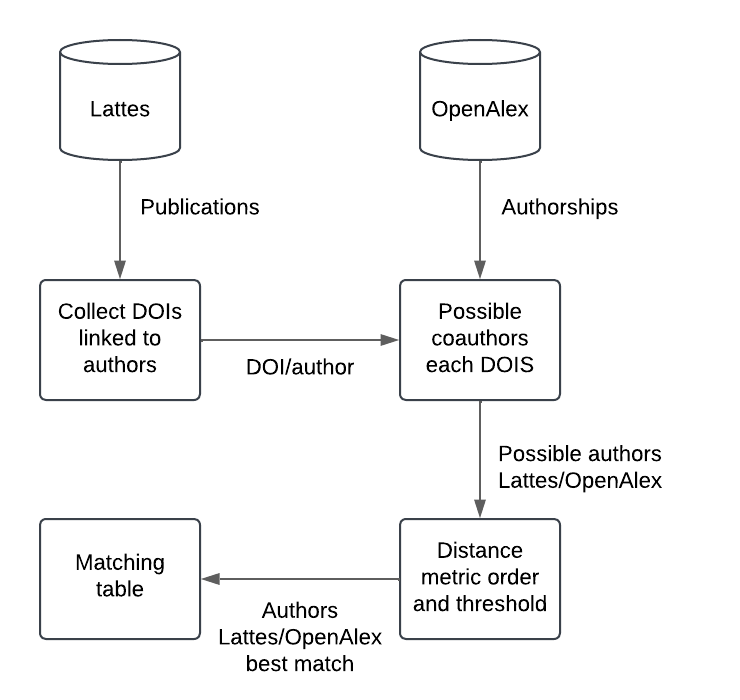

# Authors from Lattes with DOIs

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE insyspo.projectdb_lattes.authors_dois AS (
  SELECT  IDLattes, DOI
  FROM `insyspo.projectdb_lattes.artigos`
  WHERE DOI IS NOT NULL
)

Query is running:   0%|          |

""


# Table with possible correspondences from Lattes researchers to OpenAlex coauthors via DOIs

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE insyspo.projectdb_lattes.possible_authors AS (
  SELECT a.IDLattes, c.author_id, COUNT(DISTINCT(a.DOI)) AS dois
  FROM insyspo.projectdb_lattes.authors_dois AS a
  JOIN `insyspo.publicdb_openalex_2024_04_rm.works` AS b
  ON a.DOI = b.doi
  JOIN `insyspo.publicdb_openalex_2024_04_rm.works_authorships` AS c
  ON b.id = c.work_id
  GROUP BY a.IDLattes, c.author_id
)

Query is running:   0%|          |

""


# Ordering of possible correspondences by the number of DOIs in common

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE insyspo.projectdb_lattes.ids_match_doi AS (
  SELECT *
  FROM (
    SELECT IDLattes, author_id, dois,
      ROW_NUMBER() OVER (PARTITION BY IDLattes ORDER BY dois DESC) AS r
    FROM insyspo.projectdb_lattes.possible_authors
    ORDER BY IDLattes, r
  )
  WHERE r <= 10
);

Query is running:   0%|          |

""


# Enlarge table using alternative names for authors in OpenAlex

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE insyspo.projectdb_lattes.names_match_doi AS (
  SELECT ids.*,
    authors.display_name_alternative AS display_name,
    autores.Nome
  FROM insyspo.projectdb_lattes.ids_match_doi AS ids
  JOIN insyspo.publicdb_openalex_2024_04_rm.authors_display_name_alternatives AS authors
  ON ids.author_id = authors.author_id
  JOIN insyspo.projectdb_lattes.geraisIDNome AS autores
  ON ids.IDLattes = autores.IDLattes
)

Query is running:   0%|          |

""


# Distance metric function to apply on pair of candidate names

In [ ]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import Levenshtein as Lv
import plotly.express as px

## Split parts of names to compare

In [ ]:
def split_name(name):

  syms = ' -.‐—–'
  for a in syms:
    name = name.replace(a,'#')
  for i in range(4):
    name = name.replace('##','#')

  parts = name.lower().split('#')
  parts = [p for p in parts if len(p)>0]

  return parts

## Function for distance calculation based on Levenshtein distance of parts

In [ ]:
def names_distance_ordered(name_a,name_b):
  sa = split_name(name_a)
  sb = split_name(name_b)

  # Identify the name with the most parts
  if len(sa) >= len(sb):
    major = sa
    minor = sb
  else:
    major = sb
    minor = sa
  gap = len(major) - len(minor)

  not_found = 1.0
  # matrix with metric from all parts to all
  D = np.ones((len(major), len(minor)))*(not_found)

  for i,ia in enumerate(major):
    for j,ib in enumerate(minor):

      if i > (j+gap) or j > i:
        pass
      else:
        if len(ia) >=2 or len(ib) >= 2:
          # normalise the distance by the length of the part
          rd = Lv.distance(ia,ib)/len(ia)
          # print(ia,ib,rd)
          D[i,j] = rd
          # print(ia,ib,Lv.distance(ia,ib),rd)
        if len(ia)==1 or len(ib)==1:
          if ia[0] == ib[0]:
            # print(ia,ib,0)
            D[i,j] = 0
    # print(D)

  # select the minimum distance for all pairs (a matching part of name)
  # and sum all the minimums to have the full distance
  dn = D.min(axis = 0).sum()
  return dn

# Calculation of distance metrics

## Read table of possible correspondence of names

In [ ]:
%%bigquery df --project = insyspo

SELECT *
FROM `insyspo.projectdb_lattes.names_match_doi`

Query is running:   0%|          |

Downloading:   0%|          |

Apply the distance to the pairs

In [ ]:
names_distance_ordered('Cynthia Boschi‐Pinto','Cynthia Boschi Pinto')

0.0

In [ ]:
df['distance_names'] = df.apply(lambda x: names_distance_ordered(x['display_name'],x['Nome']),axis=1)

## Save the table with distances back to BigQuery.

In [ ]:
pandas_gbq.to_gbq(df,destination_table='projectdb_lattes.match_lattes_openalex_distances',
                  project_id='insyspo',if_exists = 'replace')

100%|██████████| 1/1 [00:00<00:00, 6052.39it/s]


# Sort by the most likely match

In [ ]:
%%bigquery df --project = insyspo

CREATE OR REPLACE TABLE projectdb_lattes.match_lattes_openalex_distances_sorted AS (
  SELECT IDLattes,
    author_id,
    display_name,
    Nome,
    distance_names,
    dois,
    ROW_NUMBER()
      OVER (
        PARTITION BY IDLattes
        ORDER BY distance_names ASC,
          CHAR_LENGTH(display_name) DESC # longer names when distance is equal
      ) AS seq
  FROM `insyspo.projectdb_lattes.match_lattes_openalex_distances`
)

Query is running:   0%|          |

## Show matching

In [ ]:
%%bigquery --project = insyspo

SELECT *
FROM projectdb_lattes.match_lattes_openalex_distances_sorted
WHERE seq <= 5
ORDER BY IDLattes, seq
LIMIT 40

Query is running:   0%|          |

Downloading:   0%|          |

,IDLattes,author_id,display_name,Nome,distance_names,dois,seq
0,'0000039015885890,5078821696,Tárcio A. Vieira,Tárcio de Almeida Vieira,0.000000,9,1
1,'0000039015885890,5078821696,T. A. Vieira,Tárcio de Almeida Vieira,0.000000,9,2
2,'0000039015885890,5078821696,T. Vieira,Tárcio de Almeida Vieira,0.000000,9,3
3,'0000039015885890,5078821696,Tarcio A. Vieira,Tárcio de Almeida Vieira,0.166667,9,4
4,'0000039015885890,5078821696,Tarcio Vieira,Tárcio de Almeida Vieira,0.166667,9,5
5,'0000111305956227,5074388690,Tecia Vieira Carvalho,Tecia Vieira Carvalho,0.000000,1,1
6,'0000111305956227,5074388690,Tecia V. Carvalho,Tecia Vieira Carvalho,0.000000,1,2
7,'0000111305956227,5074388690,Tecia Carvalho,Tecia Vieira Carvalho,0.000000,1,3
8,'0000111305956227,5074388690,T.V. Carvalho,Tecia Vieira Carvalho,0.000000,1,4
9,'0000111305956227,5074388690,Técia Vieira Carvalho,Tecia Vieira Carvalho,0.200000,1,5


## Select the most likely as the match respecting a threshold

The threshold varies with the number of common DOIs.

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE projectdb_lattes.match_lattes_openalex_distances_ AS (
  SELECT *
  FROM `insyspo.projectdb_lattes.match_lattes_openalex_distances_sorted`
  WHERE seq = 1 AND distance_names < (64.5 + 0.3 * dois) / 648.0
)

Query is running:   0%|          |

""


# Analysis of matching

In [ ]:
%%bigquery df --project = insyspo

SELECT *
FROM projectdb_lattes.match_lattes_openalex_distances_

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,IDLattes,author_id,display_name,Nome,distance_names,dois,seq
0,'6618345602578843,5040938666,Emílio Soares Ribeiro,Emílio Soares Ribeiro,0.0,1,1
1,'2880310911677157,5072386052,Marcia Martins,Marcia Barbosa Martins,0.0,1,1
2,'7046711043081369,5015824739,Thales Nascimento e Castro,Thales Nascimento e Castro,0.0,1,1
3,'0298971992346526,5062203970,Rosângelis Del Lama Soares,Rosângelis Del Lama Soares,0.0,1,1
4,'6112519762262688,5019996152,Andrea Abrigato de Freitas Mourão,Andrea Abrigato de Freitas Mourão,0.0,1,1
...,...,...,...,...,...,...,...
154469,'8991924818758351,5045792722,Sirlene Adriana Kleinubing,Sirlene Adriana Kleinübing,0.1,4,1
154470,'8002590846188269,5001699571,Denise Burgarelli,Denise Bulgarelli Duczmal,0.1,6,1
154471,'9572985229927350,5089270347,SebastiaÌo Gomes Silva,Sebastiao Gomes Silva,0.1,7,1
154472,'1874644681647792,5017867664,Anatoly A. Yambartsev,Anatoli Iambartsev,0.1,15,1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq

Text(0, 0.5, 'Number of authors matched')

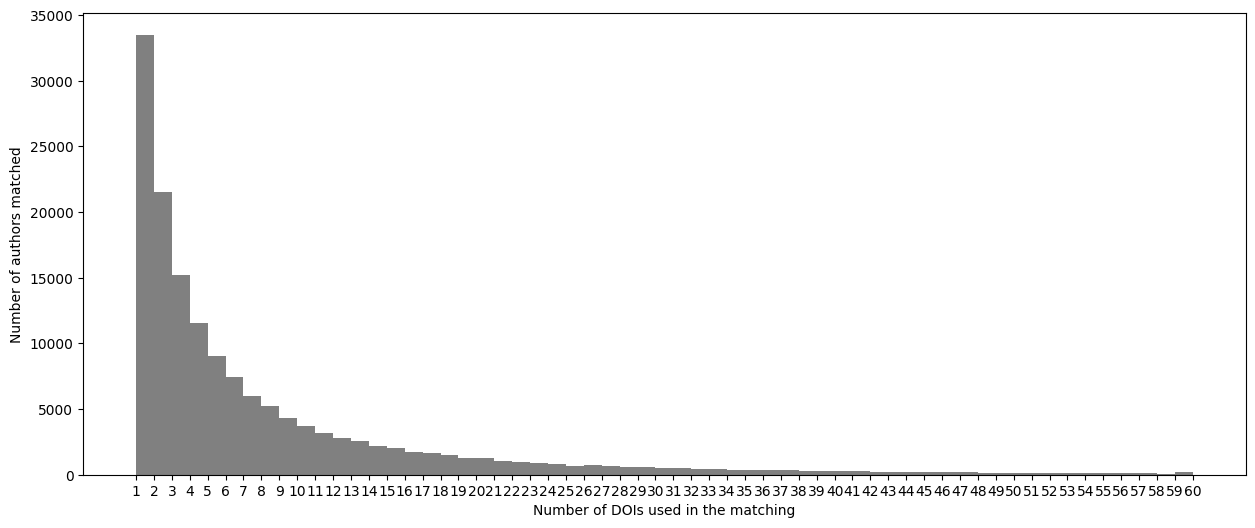

In [ ]:
plt.figure(figsize=(15,6))
xd = np.arange(60)+1
plt.hist(df['dois'],bins = xd, color = "gray")
plt.xticks(xd)
plt.xlabel('Number of DOIs used in the matching')
plt.ylabel('Number of authors matched')


In [ ]:
%%bigquery --project = insyspo

SELECT COUNT(DISTINCT(author_id)) AS oa_authors,
COUNT(DISTINCT(IDLattes)) AS authors,
FROM projectdb_lattes.match_lattes_openalex_distances_


Query is running:   0%|          |

Downloading:   0%|          |

,oa_authors,authors
0,151318,154474


In [ ]:
%%bigquery --project = insyspo

SELECT author_id, COUNT(*) AS authors
FROM projectdb_lattes.match_lattes_openalex_distances_
GROUP BY author_id
HAVING authors=1
ORDER BY authors DESC

Query is running:   0%|          |

Downloading:   0%|          |

,author_id,authors
0,5040938666,1
1,5072386052,1
2,5015824739,1
3,5062203970,1
4,5019996152,1
...,...,...
148426,5045792722,1
148427,5001699571,1
148428,5089270347,1
148429,5017867664,1


In [ ]:
%%bigquery df --project = insyspo

SELECT author_id, COUNT(*) AS authors
FROM projectdb_lattes.match_lattes_openalex_distances_
GROUP BY author_id
HAVING authors>1
ORDER BY authors DESC


Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Number of authors matched')

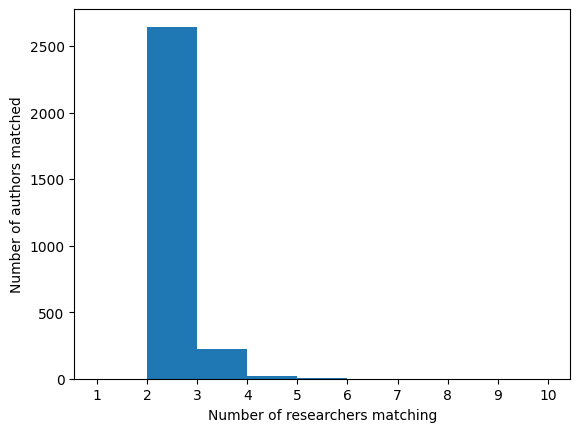

In [ ]:
#plt.figure(figsize=(14,8))
xd = np.arange(10)+1
plt.hist(df['authors'],bins = xd)
x,y = plt.xticks(xd)
plt.xlabel('Number of researchers matching')
plt.ylabel('Number of authors matched')

In [ ]:
%%bigquery --project = insyspo

SELECT authors AS author_ids,
  COUNT(*) AS researchers
FROM (
  SELECT author_id, COUNT(*) AS authors
  FROM projectdb_lattes.match_lattes_openalex_distances_
  GROUP BY author_id
  #HAVING authors>1
  ORDER BY authors DESC
)
GROUP BY authors
ORDER BY researchers DESC

Query is running:   0%|          |

Downloading:   0%|          |

,author_ids,researchers
0,1,148431
1,2,2645
2,3,220
3,4,17
4,5,5


# Researchers in Lattes split in OpenAlex

In [ ]:
%%bigquery df --project = insyspo

SELECT n AS splits, COUNT(*) AS freq
FROM (
  SELECT IDLattes, COUNT(DISTINCT(author_id)) AS n
  FROM `insyspo.projectdb_lattes.match_lattes_openalex_distances_sorted`
  WHERE distance_names < (64.5 + 0.3 * dois) / 648.0
  GROUP BY IDLattes
  #HAVING n >1
)
GROUP BY n
ORDER BY freq DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,splits,freq
0,1,137632
1,2,15526
2,3,1205
3,4,101
4,5,6
5,6,4


<Axes: xlabel='splits'>

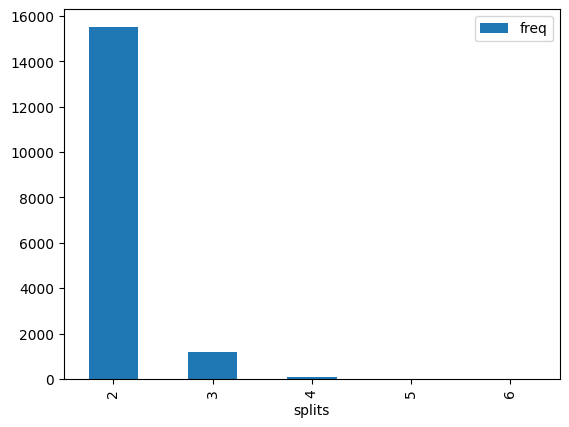

In [ ]:
df.plot.bar(x = 'splits')


In [ ]:
%%bigquery --project = insyspo
SELECT SUM(n) FROM (
  SELECT IDLattes, COUNT(DISTINCT(author_id)) AS n
  FROM `insyspo.projectdb_lattes.match_lattes_openalex_distances_sorted`
  WHERE distance_names < (64.5 + 0.3 * dois) / 648.0
  GROUP BY IDLattes
  HAVING n >1
  ORDER BY n DESC
)

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,35125


## Institutions for wrongly matched

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE projectdb_lattes.wrongly_matched AS (
  SELECT a.IDLattes, a.Nome, b.Instituicao, b.AnoFim
  FROM (
    SELECT a.IDLattes, ANY_VALUE(a.Nome) AS Nome
    FROM projectdb_lattes.match_lattes_openalex_distances_ AS a
    JOIN (
      SELECT author_id, COUNT(*) AS authors
      FROM projectdb_lattes.match_lattes_openalex_distances_
      GROUP BY author_id
      HAVING authors>1
      ORDER BY authors DESC
    ) AS b
    ON a.author_id = b.author_id
    GROUP BY a.IDLattes
  ) AS a
  JOIN `insyspo.projectdb_lattes.atuacoes` AS b
  ON a.IDLattes = b.IDLattes
  WHERE b.AnoFim IS NULL
);

Query is running:   0%|          |

Downloading:   0%|          |

,Instituicao,n
0,Universidade de São Paulo,216
1,Universidade Estadual Paulista Júlio de Mesqui...,132
2,Universidade Federal do Rio de Janeiro,130
3,Universidade Federal de Pernambuco,121
4,Universidade Federal de Minas Gerais,107
...,...,...
724,Vert,1
725,Vertex Pharmaceuticals,1
726,Westfälische Wilhelms Universität Münster,1
727,consultório de psicoterapia,1


In [ ]:
%%bigquery df --project = insyspo

SELECT Instituicao AS institution, COUNT(*) AS authors
FROM projectdb_lattes.wrongly_matched
GROUP BY Instituicao
ORDER BY authors DESC
LIMIT 10;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.head()

,institution,authors
0,Universidade de São Paulo,216
1,Universidade Estadual Paulista Júlio de Mesqui...,132
2,Universidade Federal do Rio de Janeiro,130
3,Universidade Federal de Pernambuco,121
4,Universidade Federal de Minas Gerais,107


<Axes: ylabel='Institution'>

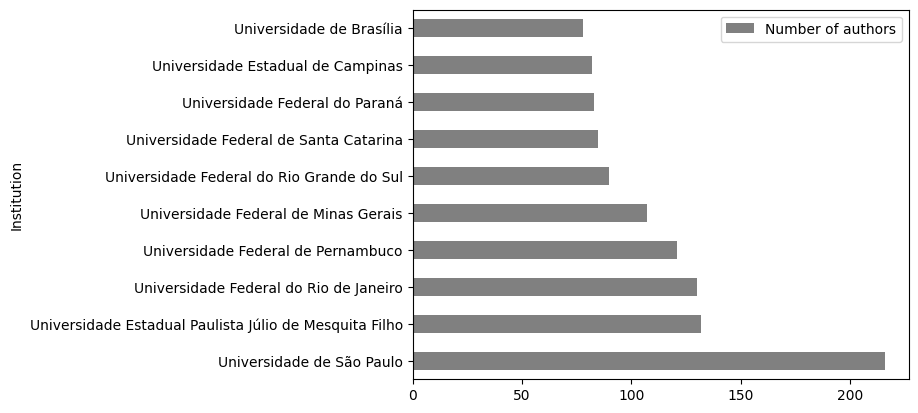

In [ ]:
df = df.rename(columns={'institution': 'Institution', 'authors': 'Number of authors'})

df.plot.barh(x = 'Institution', color={'Number of authors': 'gray'})

## Institutions for correctly matched

In [ ]:
%%bigquery --project = insyspo

CREATE OR REPLACE TABLE projectdb_lattes.correctly_matched AS (
  SELECT a.IDLattes, a.Nome, b.Instituicao, b.AnoFim
  FROM (
    SELECT a.IDLattes, ANY_VALUE(a.Nome) AS Nome
    FROM projectdb_lattes.match_lattes_openalex_distances_ AS a
    JOIN (
      SELECT author_id, COUNT(*) AS authors
      FROM projectdb_lattes.match_lattes_openalex_distances_
      GROUP BY author_id
      HAVING authors=1
      ORDER BY authors DESC
    ) AS b
    ON a.author_id = b.author_id
    GROUP BY a.IDLattes
  ) AS a
  JOIN `insyspo.projectdb_lattes.atuacoes` AS b
  ON a.IDLattes = b.IDLattes
  WHERE b.AnoFim IS NULL
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery df --project = insyspo

SELECT Instituicao AS institution, COUNT(*) AS authors
FROM projectdb_lattes.correctly_matched
GROUP BY Instituicao
ORDER BY authors DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: ylabel='Institution'>

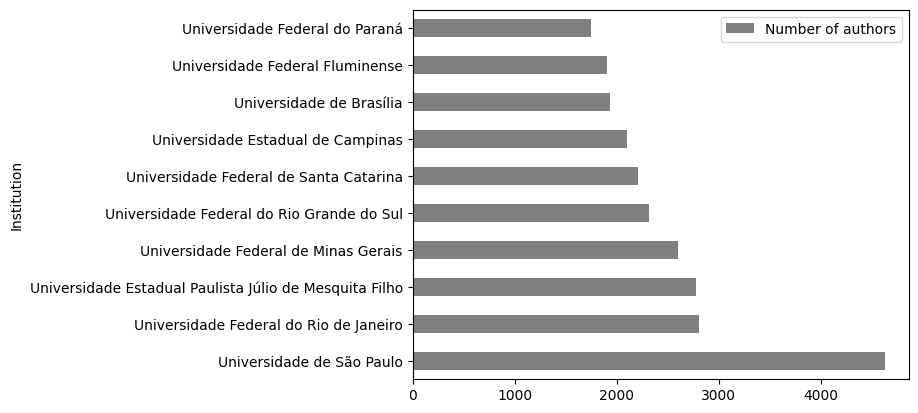

In [ ]:
df = df.rename(columns={'institution': 'Institution', 'authors': 'Number of authors'})

df.plot.barh(x = 'Institution', color={'Number of authors': 'gray'})

# Comparison of authors by research field.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source = r"/content/drive/MyDrive/Mobilidade/areas.csv" # Caminho da tabela "areas.csv"

dfAreas = pd.read_csv(source,
                  delimiter='\t',
                  header=None,
                  names=["IDLattes", "Col2", "BigArea", "MediumArea","SmallArea1", "SmallArea2"],
                  dtype={"IDLattes": "str", "Col2": "str", "BigArea": "str", "MediumArea":"str", "SmallArea1":"str", "SmallArea2":"str"},
                  usecols=[0,2]
                  )

dfAreas.drop_duplicates()

In [ ]:
wrongly_table = 'insyspo.projectdb_lattes.wrongly_matched'
correctly_table = 'insyspo.projectdb_lattes.correctly_matched'

# Load data from BigQuery
wrongly_df = pd.read_gbq(wrongly_table)
correctly_df = pd.read_gbq(correctly_table)

<ipython-input-71-105a2f92bf8a>:5: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  wrongly_df = pd.read_gbq(wrongly_table)
<ipython-input-71-105a2f92bf8a>:6: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  correctly_df = pd.read_gbq(correctly_table)


In [ ]:
#Standardize IDLattes string
def correctIDs(id):
    id = id.replace("'","")
    return id

wrongly_df['IDLattes'] = wrongly_df['IDLattes'].apply(correctIDs)
correctly_df['IDLattes'] = correctly_df['IDLattes'].apply(correctIDs)

df_areas_wrong = wrongly_df.merge(dfAreas, on='IDLattes', how='left')

df_areas_correct = correctly_df.merge(dfAreas, on='IDLattes', how='left')

In [ ]:
data_correct = df_areas_correct[['BigArea']].value_counts(normalize=True).reset_index(name='Correct authors')

data_wrong = df_areas_wrong[['BigArea']].value_counts(normalize=True).reset_index(name='Incorrect authors')

merged = data_correct.merge(data_wrong, on='BigArea', how='left')

merged = merged.rename(columns={'BigArea': 'Research field', 'Correct authors': 'Correctly classified', 'Incorrect authors': 'Misclassified'})

#ax = merged.plot.barh(x = 'BigArea', y = 'Proportion')

merged['Misclassified'] = merged['Misclassified']*100
merged['Correctly classified'] = merged['Correctly classified']*100

merged

,Research field,Correctly classified,Misclassified
0,CIENCIAS_EXATAS_E_DA_TERRA,16.629729,19.277471
1,CIENCIAS_BIOLOGICAS,16.313344,15.334215
2,CIENCIAS_HUMANAS,14.672354,9.894205
3,CIENCIAS_DA_SAUDE,14.537788,16.013465
4,CIENCIAS_AGRARIAS,12.944050,16.211830
5,ENGENHARIAS,11.585803,13.807406
6,CIENCIAS_SOCIAIS_APLICADAS,7.973826,5.800673
7,LINGUISTICA_LETRAS_E_ARTES,4.175152,2.638855
8,OUTROS,1.167954,1.021880


In [ ]:
merged.iloc[0,0] = 'Exact and Earth Sciences'
merged.iloc[1,0] = 'Biological Sciences'
merged.iloc[2,0] = 'Humanities'
merged.iloc[3,0] = 'Health Sciences'
merged.iloc[4,0] = 'Agricultural Sciences'
merged.iloc[5,0] = 'Engineering'
merged.iloc[6,0] = 'Applied Social Sciences'
merged.iloc[7,0] = 'Linguistics, Letters and Arts'
merged.iloc[8,0] = 'Others'

merged


,Research field,Correctly classified,Misclassified
0,Exact and Earth Sciences,16.629729,19.277471
1,Biological Sciences,16.313344,15.334215
2,Humanities,14.672354,9.894205
3,Health Sciences,14.537788,16.013465
4,Agricultural Sciences,12.944050,16.211830
5,Engineering,11.585803,13.807406
6,Applied Social Sciences,7.973826,5.800673
7,"Linguistics, Letters and Arts",4.175152,2.638855
8,Others,1.167954,1.021880


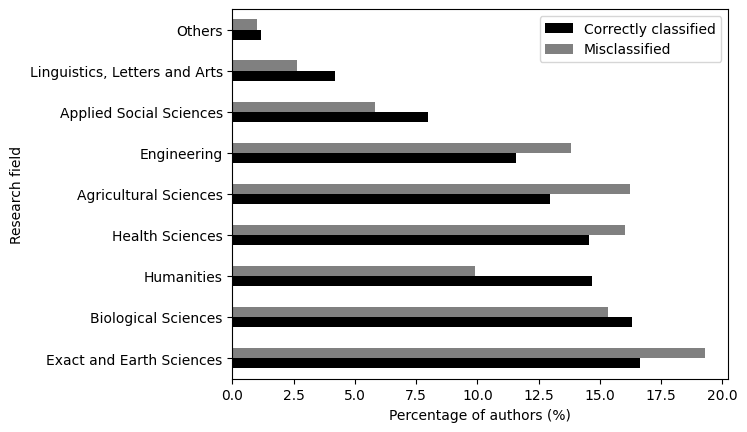

In [ ]:
ax = merged.plot.barh(color={'Correctly classified': 'black', 'Misclassified': 'gray'}, x='Research field', ylabel='Research field', xlabel='Percentage of authors (%)')